In [1]:
# This is an example of the comparison of images using the HOG technique
#
# Prepared by Juan D. Soler (soler@mpia.de)

import sys
sys.path.append('../')
from astrohog2d import *
from statests import *

import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from astropy.io import fits

from scipy import ndimage

In [2]:
# Load the images that you want to compare
# astroHOG assumes that the cubes are spatially aligned and are reprojected into the same grid

hdul = fits.open('../data/testimage1.fits')
image1=hdul[0].data
hdul.close()
hdul = fits.open('../data/testimage2.fits')
image2=hdul[0].data
hdul.close()

# In case the images are in png format
#image1 = scipy.ndimage.imread('../data/image.001.png', flatten=True)
#image2 = scipy.ndimage.imread('../data/image.002.png', flatten=True)

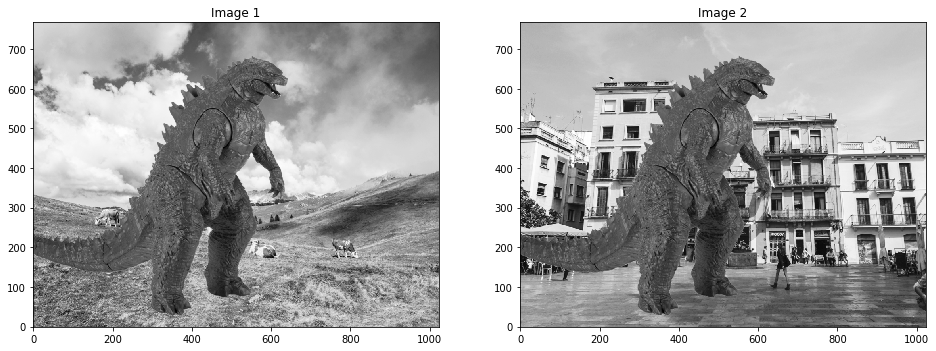

In [3]:
fig, ax = plt.subplots(1,2, figsize=(16., 12.))
ax[0].imshow(image1, origin='lower', interpolation='none', cmap='Greys_r')
ax[0].set_title('Image 1')
ax[1].imshow(image2, origin='lower', interpolation='none', cmap='Greys_r')
ax[1].set_title('Image 2')
plt.show()

In [4]:
# Here you select the size of your derivative kernel in pixels
ksz=9

In [6]:
# Here I define the masks for both images
# For the sake of simplicity, I'm only masking the edges
sz1=np.shape(image1)
mask1=1.+0.*image1
mask1[0:ksz,:]=0.
mask1[sz1[0]-1-ksz:sz1[0],:]=0.
mask1[:,0:ksz]=0.
mask1[:,sz1[1]-1-ksz:sz1[1]]=0.
sz2=np.shape(image2)
mask2=1.+0.*image2
mask2[0:ksz,:]=0.
mask2[sz2[0]-1-ksz:sz2[0],:]=0.
mask2[:,0:ksz]=0.
mask2[:,sz2[1]-1-ksz:sz2[1]]=0.

In [8]:
# Calculate the relative orientation angles using the tools in the astroHOG package
circstats, corrframe, simage1, simage2 = HOGcorr_imaLITE(image1, image2, ksz=ksz, mask1=mask1, mask2=mask2)

In [9]:
# Print the correlation statistics obtained by astrohog
print('Mean resultant vector (r)        ', circstats['RVL'])
print('Rayleigh statistic (Z)           ', circstats['Z'])
print('Projected Rayleigh statistic (V) ', circstats['V'])
print('Pearson correlation coefficient  ', circstats['pearsonr'])
print('Cross correlation                ', circstats['crosscor'])
print('Number of gradient pairs         ', circstats['ngood'])

Mean resultant vector (r)         0.23650952432133207
Rayleigh statistic (Z)            290.1934276091106
Projected Rayleigh statistic (V)  289.8030382485904
Pearson correlation coefficient   0.40454575
Cross correlation                 0.9019265
Number of gradient pairs          752745.0


In [10]:
# Calculate the relative orientation angles and uncertainties using standard deviation values
circstats, corrframe, smoothframe1, smoothframe2 = HOGcorr_ima(image1, image2, ksz=ksz, mask1=mask1, mask2=mask2, s_ima1=0.1*np.nanmin(image1), s_ima2=0.1*np.nanmin(image2), nruns=3)

  0%|          | 0/9 [00:00<?, ?it/s]

Running astroHOG Montecarlo ========================================


100%|██████████| 9/9 [00:04<00:00,  1.97it/s]


In [11]:
# Print the correlation statistics obtained by astrohog
print('Mean resultant vector (r)        ', circstats['RVL'], '+/-', circstats['s_RVL'])
print('Rayleigh statistic (Z)           ', circstats['Z'], '+/-', circstats['s_Z'])
print('Projected Rayleigh statistic (V) ', circstats['V'], '+/-', circstats['s_V'])
print('Number of gradient pairs         ', circstats['ngood'])

Mean resultant vector (r)         0.2365060895664307 +/- 3.73965854549131e-05
Rayleigh statistic (Z)            290.1892132194335 +/- 0.0458850160270567
Projected Rayleigh statistic (V)  289.80079273963327 +/- 0.04747304020041794
Number of gradient pairs          752745.0


In [13]:
# Calculate the relative orientation angles and uncertainties using standard deviation maps
circstats, corrframe, simage1, simage2 = HOGcorr_ima(image1, image2, ksz=ksz, mask1=mask1, mask2=mask2, s_ima1=0.1*image1, s_ima2=0.1*image2, nruns=3)

  0%|          | 0/9 [00:00<?, ?it/s]

Running astroHOG Montecarlo ========================================


100%|██████████| 9/9 [00:04<00:00,  1.98it/s]


In [14]:
# Print the correlation statistics obtained by astrohog
print('Mean resultant vector (r)        ', circstats['RVL'], '+/-', circstats['s_RVL'])
print('Rayleigh statistic (Z)           ', circstats['Z'], '+/-', circstats['s_Z'])
print('Projected Rayleigh statistic (V) ', circstats['V'], '+/-', circstats['s_V'])
print('Number of gradient pairs         ', circstats['ngood'])

Mean resultant vector (r)         0.21250958087984284 +/- 0.0017563327874516122
Rayleigh statistic (Z)            260.74587842606746 +/- 2.154992417643097
Projected Rayleigh statistic (V)  260.72276599153116 +/- 2.1556751614531984
Number of gradient pairs          752745.0


In [15]:
# For the sake of illustration, here we calculate the gradients that underlie astroHOG
dI1dx=ndimage.filters.gaussian_filter(smoothframe1, [ksz, ksz], order=[0,1], mode='nearest')
dI1dy=ndimage.filters.gaussian_filter(smoothframe1, [ksz, ksz], order=[1,0], mode='nearest')
normgrad1=np.sqrt(dI1dx**2+dI1dy**2)
udI1dx=dI1dx/normgrad1
udI1dy=dI1dy/normgrad1
psi1=np.arctan2(dI1dy,dI1dx)

dI2dx=ndimage.filters.gaussian_filter(smoothframe2, [ksz, ksz], order=[0,1], mode='nearest')
dI2dy=ndimage.filters.gaussian_filter(smoothframe2, [ksz, ksz], order=[1,0], mode='nearest')
normgrad2=np.sqrt(dI2dx**2+dI2dy**2)
udI2dx=dI2dx/normgrad2
udI2dy=dI2dy/normgrad2
psi2=np.arctan2(dI2dy,dI2dx)

In [19]:
# This is just setting up the vector representation
pitch=50
sz=np.shape(image1)
X, Y = np.meshgrid(np.arange(0, sz[1]-1, pitch), np.arange(0, sz[0]-1, pitch))
ux1=dI1dx[Y,X]
uy1=dI1dy[Y,X]
ux2=dI2dx[Y,X]
uy2=dI2dy[Y,X]
ux1=np.cos(psi1[Y,X])
uy1=np.sin(psi1[Y,X])
ux2=np.cos(psi2[Y,X])
uy2=np.sin(psi2[Y,X])

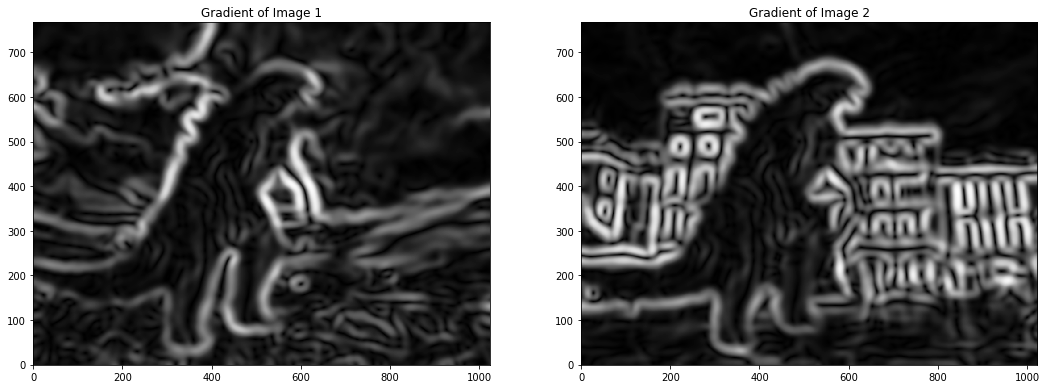

In [20]:
fig, ax = plt.subplots(1,2, figsize=(18., 12.))
ax[0].imshow(normgrad1, origin='lower', interpolation='none', cmap='Greys_r')
ax[0].set_title('Gradient of Image 1')
ax[1].imshow(normgrad2, origin='lower', interpolation='none', cmap='Greys_r')
ax[1].set_title('Gradient of Image 2')
plt.show()

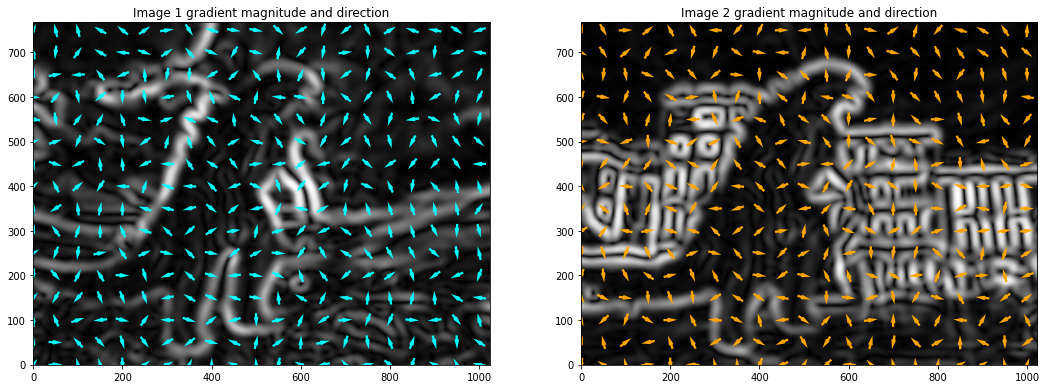

In [21]:
fig, ax = plt.subplots(1,2, figsize=(18., 12.))
ax[0].imshow(normgrad1, origin='lower', cmap='Greys_r')
arrows1=ax[0].quiver(X, Y, ux1, uy1, units='width', color='cyan', pivot='middle', width=0.005, headwidth=2, headlength=4)
ax[0].set_title('Image 1 gradient magnitude and direction')
ax[1].imshow(normgrad2, origin='lower', cmap='Greys_r')
arrows2=ax[1].quiver(X, Y, ux2, uy2, units='width', color='orange',  pivot='middle', width=0.005, headwidth=2, headlength=4)
ax[1].set_title('Image 2 gradient magnitude and direction')
plt.show()

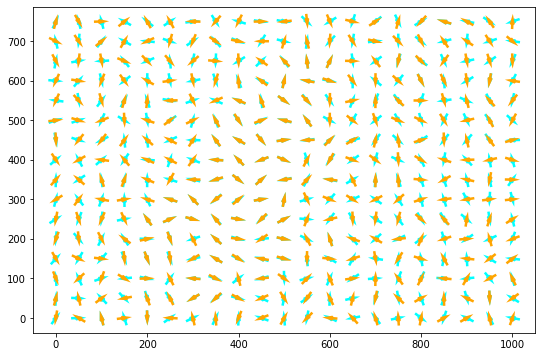

In [22]:
fig, ax = plt.subplots(figsize=(9., 6.))
arrows1=ax.quiver(X, Y, ux1, uy1, units='width', color='cyan',   pivot='middle',  width=0.005, headwidth=2, headlength=4)
arrows2=ax.quiver(X, Y, ux2, uy2, units='width', color='orange',  pivot='middle', width=0.005, headwidth=2, headlength=4)
plt.show()

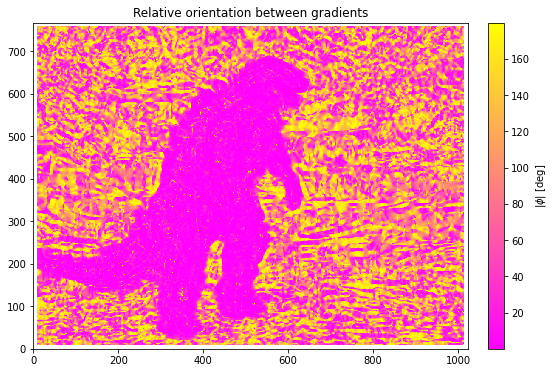

In [23]:
fig, ax = plt.subplots(1,1, figsize=(9., 6.))
im=plt.imshow(np.abs(corrframe)*180.0/np.pi, origin='lower', cmap='spring', interpolation='none')
cb1=plt.colorbar(im,fraction=0.046, pad=0.04)
cb1.set_label(r'$|\phi|$ [deg]')
ax.set_title('Relative orientation between gradients')
plt.show()